In [24]:
import pandas as pd
import numpy as np

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!unzip /content/drive/MyDrive/Datos/Tweets.zip

Archive:  /content/drive/MyDrive/Datos/Tweets.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Leemos los datos de nuestro dataframe de Tweets


In [27]:
data = pd.read_csv('/content/Tweets.csv')
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [28]:
df=data[data['airline_sentiment']!='neutral']
df.reset_index(inplace=True,drop=True)

Nos deshacemos de las opiniones neutrales ya que no nos interesan y empeorarían la precisión de nuestr modelo

In [29]:
X = df['text']
y=df['airline_sentiment']
X=np.array(X)
y=np.array(y)

Creamos nuestra lista de etiquetas asignando 1 a las opiniones positivas y 0 a las negativas

In [30]:
labels=[]
for i in y:
  if i=='negative':
    labels.append(0)
  else:
    labels.append(1)

Ahora procedemos a tokenizar los tweets

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 6500
validation_samples = 3000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [32]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 13233 unique tokens.
Shape of data tensor: (11541, 100)
Shape of label tensor: (11541,)


Dividimos nuestros datos en train y validación

In [33]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [34]:
x_train

array([[   0,    0,    0, ..., 3559, 2330,   19],
       [   0,    0,    0, ...,    8,    1, 3120],
       [   0,    0,    0, ...,  644,   46, 2359],
       ...,
       [   0,    0,    0, ..., 1249, 6592, 6593],
       [   0,    0,    0, ...,    7,   20, 6135],
       [   0,    0,    0, ...,   47,   50, 8403]], dtype=int32)

Creamos nuestro primer modelo

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(33, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 33)                330033    
                                                                 
 dense_5 (Dense)             (None, 1)                 34        
                                                                 
Total params: 1330067 (5.07 MB)
Trainable params: 1330067 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/10
650/650 [==============================] - 10s 14ms/step - loss: 0.3399 - acc: 0.8525 - val_loss: 0.2489 - val_acc: 0.9020
Epoch 2/10
650/650 [==============================] - 5s 7ms/step - loss: 0.2037 - acc: 0.9183 - val_loss: 0.2806 - val_acc: 0.9023
Epoch 3/10
650/650 [==============================] - 3s 4ms/step - loss: 0.1362 - acc: 0.9480 - val_loss: 0.2669 - val_acc: 0.9087
Epoch 4/10
650/650 [==============================] - 3s 4ms/step - loss: 0.0735 - acc: 0.9718 - val_loss: 0.3008 - val_acc: 0.9040
Epoch 5/10
650/650 [==============================] - 3s 4ms/step - loss: 0.0376 - acc: 0.9880 - val_loss: 0.3678 - val_acc: 0.8957
Epoch 6/10
650/650 [==============================] - 4s 6ms/step - loss: 0.0183 - acc: 0.9934 - val_loss: 0.4039 - val_acc: 0.9093
Epoch 7/10
650/650 [==============================] - 4s 5ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 0.4927 - val_acc: 0.9060
Epoch 8/10
650/650 [==============================] - 3s 4ms/step - loss: 

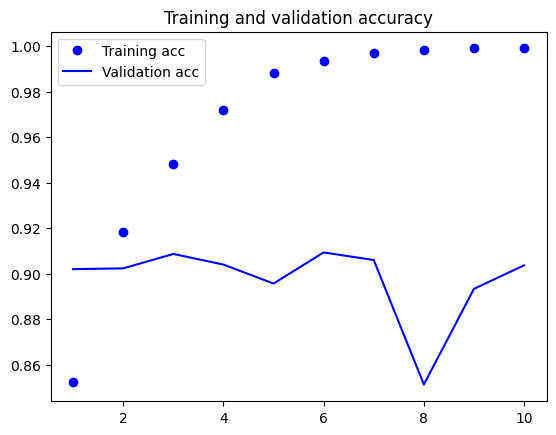

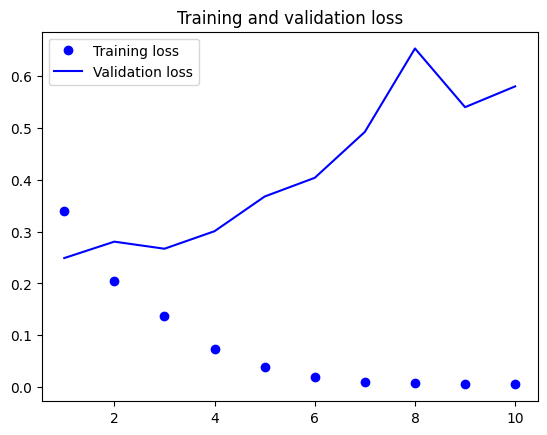

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
model.evaluate(x_val, y_val)

94/94 [==============================] - 0s 3ms/step - loss: 0.5806 - acc: 0.9037


[0.5805651545524597, 0.9036666750907898]

Con este modelo tras varias pruebas de epochs, batch size y estructura de neuronas llegamos a una precisión de mas del 90% aunque con algo de overfitting

Hagamos ahora un modelo con GloVe

In [39]:
import os

In [40]:
glove_dir = 'drive/MyDrive/Datos'
embeddings_index = {}
f = open(os.path.join(glove_dir,"glove.6B.100d.txt"), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [41]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Construimos nuestro modelo

In [42]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 16)                160016    
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1160033 (4.43 MB)
Trainable params: 1160033 (4.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Seteamos los pesos

In [43]:
model.layers[0].set_weights([embedding_matrix])

In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/10
110/110 [==============================] - 10s 86ms/step - loss: 0.3843 - acc: 0.8363 - val_loss: 0.3129 - val_acc: 0.8720
Epoch 2/10
110/110 [==============================] - 3s 23ms/step - loss: 0.2613 - acc: 0.9010 - val_loss: 0.2662 - val_acc: 0.8945
Epoch 3/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1940 - acc: 0.9259 - val_loss: 0.2648 - val_acc: 0.8975
Epoch 4/10
110/110 [==============================] - 2s 13ms/step - loss: 0.1509 - acc: 0.9453 - val_loss: 0.2716 - val_acc: 0.9015
Epoch 5/10
110/110 [==============================] - 1s 10ms/step - loss: 0.1169 - acc: 0.9586 - val_loss: 0.2399 - val_acc: 0.9120
Epoch 6/10
110/110 [==============================] - 1s 9ms/step - loss: 0.0847 - acc: 0.9716 - val_loss: 0.2820 - val_acc: 0.8923
Epoch 7/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0624 - acc: 0.9814 - val_loss: 0.2709 - val_acc: 0.9062
Epoch 8/10
110/110 [==============================] - 2s 15ms/step - l

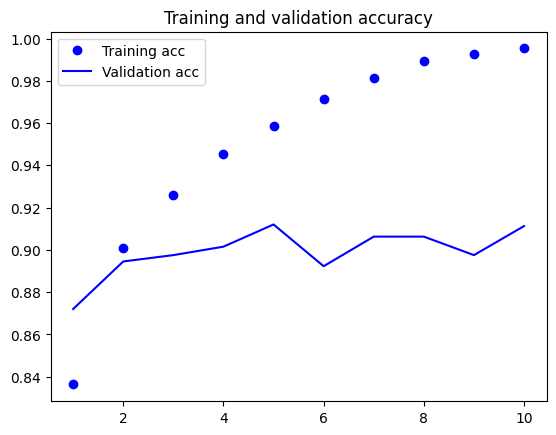

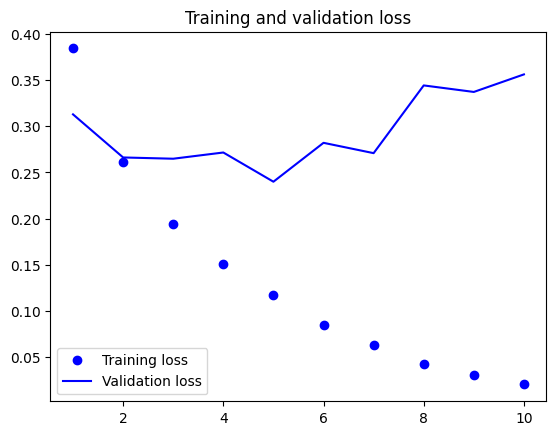

In [22]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
model.evaluate(x_val, y_val)

125/125 [==============================] - 0s 3ms/step - loss: 0.3562 - acc: 0.9112


[0.3562372624874115, 0.9112499952316284]

Este modelo consigue aun más precisión que el anterior un 91% y además tiene menos overfitting que el anterior por lo que concluimos que este es un modelo estrictamente mejor

Ahora haremos un modelo con Word2Vec

In [44]:
from gensim.models import Word2Vec

import gensim

In [46]:
X_word = df["text"].apply(gensim.utils.simple_preprocess)
X_word

0        [virginamerica, plus, you, ve, added, commerci...
1        [virginamerica, it, really, aggressive, to, bl...
2        [virginamerica, and, it, really, big, bad, thi...
3        [virginamerica, seriously, would, pay, flight,...
4        [virginamerica, yes, nearly, every, time, fly,...
                               ...                        
11536    [americanair, my, flight, was, cancelled, flig...
11537     [americanair, right, on, cue, with, the, delays]
11538    [americanair, thank, you, we, got, on, differe...
11539    [americanair, leaving, over, minutes, late, fl...
11540    [americanair, you, have, my, money, you, chang...
Name: text, Length: 11541, dtype: object

In [47]:
X_word=np.array(X_word)

Usamos Word2Vec pa hacer nuestro modelo

In [70]:
model = Word2Vec(X_word, vector_size=100, window=10, min_count=1, workers=4)

In [71]:
X_train=[]
X_test=[]
X_val=[]
Xword_train=X_word[:6500]
Xword_val=X_word[6000:9000]
Xword_test=X_word[9000:]

In [72]:
Xword_train=np.array(Xword_train)
Xword_val=np.array(Xword_val)
Xword_test=np.array(Xword_test)

In [73]:
Xword_train

array([list(['virginamerica', 'plus', 'you', 've', 'added', 'commercials', 'to', 'the', 'experience', 'tacky']),
       list(['virginamerica', 'it', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', 'faces', 'amp', 'they', 'have', 'little', 'recourse']),
       list(['virginamerica', 'and', 'it', 'really', 'big', 'bad', 'thing', 'about', 'it']),
       ...,
       list(['jetblue', 'hey', 'you', 'guys', 'remembered', 'lol', 'but', 'now', 'my', 'bos', 'flights', 'delayed', 'and', 'turn', 'the', 'heat', 'down', 'in', 'it', 'feels', 'hotter', 'than', 'pr']),
       list(['jetblue', 'thanks']),
       list(['jetblue', 'spoken', 'to', 'reps', 'once', 'allowed', 'to', 'check', 'my', 'bag', 'and', 'through', 'the', 'tsa', 'checkpoint', 'guarantee', 'will', 'be', 'talking', 'to', 'someone'])],
      dtype=object)

Pasamos nuestras frases a vectores para poder entrenar el modelo

In [74]:
for i in Xword_train:
   sentence_vector = np.mean([model.wv[word] for word in i], axis=0)
   X_train.append(sentence_vector)
for i in Xword_val:
   sentence_vector = np.mean([model.wv[word] for word in i], axis=0)
   X_val.append(sentence_vector)
for i in Xword_test:
   sentence_vector = np.mean([model.wv[word] for word in i], axis=0)
   X_test.append(sentence_vector)


In [75]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)

Definimos nuestro modelo

In [76]:
model= Sequential()
model.add(Dense(64, input_dim=100, activation='relu'))
model.add(Dense(64, input_dim=100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
len(X_val)

3000

In [78]:
len(y_val)

3000

Entrenamos el modelo

In [79]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/10
407/407 [==============================] - 4s 6ms/step - loss: 0.5119 - accuracy: 0.7968 - val_loss: 0.5062 - val_accuracy: 0.7977
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.5084 - accuracy: 0.7968 - val_loss: 0.5044 - val_accuracy: 0.7977
Epoch 3/10
407/407 [==============================] - 2s 5ms/step - loss: 0.5077 - accuracy: 0.7968 - val_loss: 0.5170 - val_accuracy: 0.7973
Epoch 4/10
407/407 [==============================] - 2s 4ms/step - loss: 0.5088 - accuracy: 0.7968 - val_loss: 0.5045 - val_accuracy: 0.7977
Epoch 5/10
407/407 [==============================] - 2s 4ms/step - loss: 0.5067 - accuracy: 0.7968 - val_loss: 0.5082 - val_accuracy: 0.7973
Epoch 6/10
407/407 [==============================] - 2s 4ms/step - loss: 0.5065 - accuracy: 0.7968 - val_loss: 0.5068 - val_accuracy: 0.7973
Epoch 7/10
407/407 [==============================] - 2s 6ms/step - loss: 0.5063 - accuracy: 0.7968 - val_loss: 0.5062 - val_accuracy: 0.7977
Epoch 

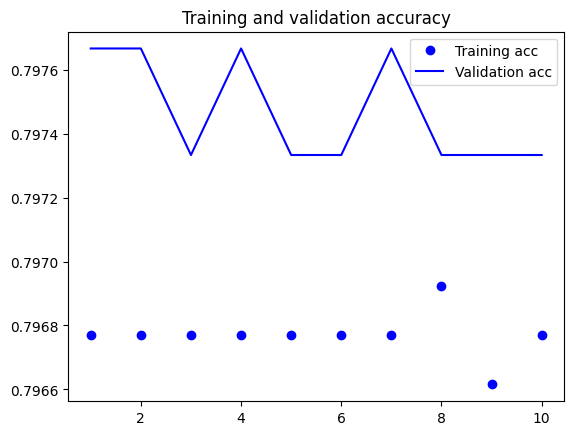

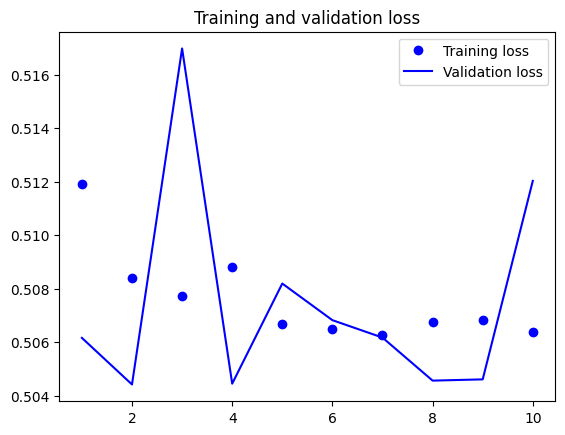

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
model.evaluate(X_val, y_val)

94/94 [==============================] - 0s 4ms/step - loss: 0.5120 - accuracy: 0.7973


[0.5120306611061096, 0.7973333597183228]

Con este modelo obtenemo una precisión de 80% aunque podemos observar como no funciona del todo bien este tipo de modelo con nuestros datos

#Conclusión

Tenemos varias maneras de enfrentar un problema de clasificaciión con NLPs, como hemos comprobado, utilizar GloVe ha sido lo más óptimo en este caso al tratar nuestros datos mientras que otros modelos como Word2Vec no han sabido interpretarlos bien.
